In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate, GlobalAveragePooling2D
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv2D, MaxPooling2D,
    AveragePooling2D, GlobalAveragePooling2D, Flatten,
    BatchNormalization, Activation, Concatenate
)


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers


source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
train_dir = os.path.join(source_folder, "train")
test_dir = os.path.join(source_folder, "test")


IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False


def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)


train_features = vgg19_model.predict(train_data, batch_size=BATCH_SIZE, verbose=1)
test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


train_features = train_features.reshape(-1, 7, 7, 512)  # VGG19 output shape
test_features = test_features.reshape(-1, 7, 7, 512)

# Defining the custom InceptionV2 model

def InceptionV2(input_shape):
    input_layer = Input(shape=input_shape)


    def factorized_conv(prev_layer, nbr_kernels, filter_size):
        x = Conv2D(filters=nbr_kernels, kernel_size=(1, filter_size), padding='same', activation='relu')(prev_layer)
        x = Conv2D(filters=nbr_kernels, kernel_size=(filter_size, 1), padding='same', activation='relu')(x)
        return x


    def conv_Block(prev_layer, nbr_kernels, filter_size, stride=(1, 1), padding='valid'):
        x = Conv2D(filters=nbr_kernels, kernel_size=filter_size, strides=stride, padding=padding)(prev_layer)
        x = BatchNormalization(axis=3)(x)
        x = layers.Activation('relu')(x)
        return x


    def InceptionBlock(prev_layer):

        branch1x1 = conv_Block(prev_layer, 64, (1, 1))


        branch3x3 = conv_Block(prev_layer, 128, (1, 1))
        branch3x3 = conv_Block(branch3x3, 128, (3, 3), padding='same')


        branch5x5 = conv_Block(prev_layer, 32, (1, 1))
        branch5x5 = conv_Block(branch5x5, 64, (5, 5), padding='same')


        branch_pool = MaxPooling2D(pool_size=3, strides=1, padding='same')(prev_layer)
        branch_pool = conv_Block(branch_pool, 64, (1, 1))

        out = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=3)
        return out


    out = InceptionBlock(input_layer)


    out = AveragePooling2D(pool_size=3)(out)


    out = Flatten()(out)
    out = Dense(1024, activation='relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model(inputs=input_layer, outputs=out)
    return model


inception_v2_model = InceptionV2(input_shape=(7, 7, 512))


inception_v2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

inception_v2_model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE,
    epochs=30,
)


test_loss, test_acc = inception_v2_model.evaluate(test_features, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

inception_v2_model.save("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v2_with_vgg19_features.h5")
print("Model saved as 'inception_v2_with_vgg19_features.h5'")


Test Accuracy: 94.96%
Model saved as 'inception_v2_with_vgg19_features.h5'


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Precision: 0.9321
Recall: 0.9805
F1 Score: 0.9557
Confusion Matrix:
[[113  11]
 [  3 151]]


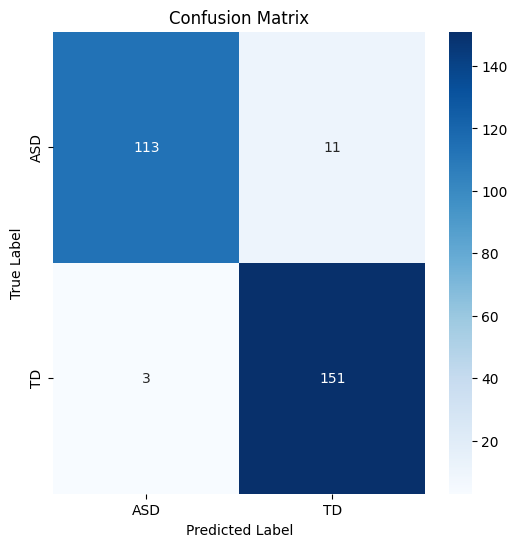

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")

IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False


def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)


test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)

inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v2_with_vgg19_features.h5")


predicted_probs = inception_model.predict(test_features, batch_size=BATCH_SIZE)
predicted_labels = (predicted_probs > 0.5).astype(int)

# Computing precision, recall, F1 score, and confusion matrix
precision = precision_score(test_labels_encoded, predicted_labels)
recall = recall_score(test_labels_encoded, predicted_labels)
f1 = f1_score(test_labels_encoded, predicted_labels)
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step


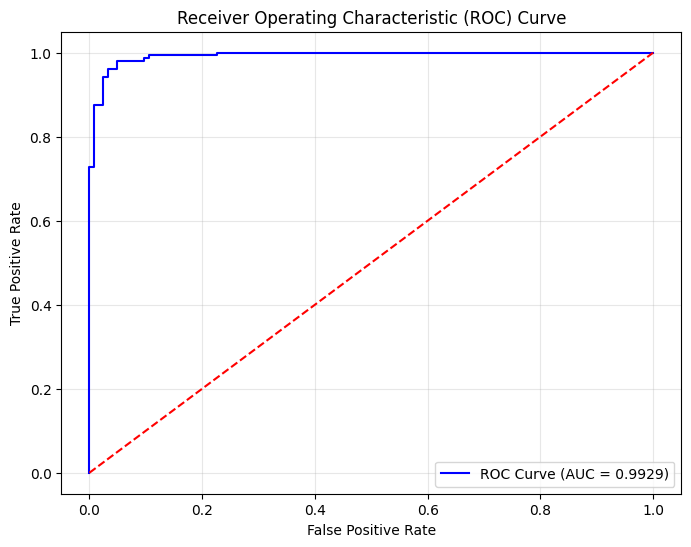

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")


IMG_SIZE = (224, 224)
BATCH_SIZE = 32


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False


def load_data(directory):
    data = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)


test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


test_features_reshaped = test_features.reshape(test_features.shape[0], 7, 7, 512)


inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v2_with_vgg19_features.h5")


predicted_probs = inception_model.predict(test_features_reshaped, batch_size=BATCH_SIZE)


fpr, tpr, thresholds = roc_curve(test_labels_encoded, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()
